# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1330s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1616, 32, 20, 3)
(1616, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
404/404 [==============================] - 7s 15ms/step - loss: 2.2657 - accuracy: 0.2740
Epoch 2/500
404/404 [==============================] - 6s 15ms/step - loss: 1.5943 - accuracy: 0.4829
Epoch 3/500
404/404 [==============================] - 6s 15ms/step - loss: 1.1584 - accuracy: 0.6307
Epoch 4/500
404/404 [==============================] - 6s 15ms/step - loss: 0.9186 - accuracy: 0.7075
Epoch 5/500
404/404 [==============================] - 7s 16ms/step - loss: 0.7531 - accuracy: 0.7715
Epoch 6/500
404/404 [==============================] - 6s 16ms/step - loss: 0.7310 - accuracy: 0.7800
Epoch 7/500
404/404 [==============================] - 7s 16ms/step - loss: 0.5607 - accuracy: 0.8251
Epoch 8/500
404/404 [==============================] - 7s 16ms/step - loss: 0.4966 - accuracy: 0.8524
Epoch 9/500
404/404 [==============================] - 7s 16ms/step - loss: 0.4420 - accuracy: 0.8607
Epoch 10/500
404/404 [==============================] - 8s 20ms/step - loss: 0.428

404/404 [==============================] - 7s 18ms/step - loss: 0.1386 - accuracy: 0.9609
Epoch 79/500
404/404 [==============================] - 7s 18ms/step - loss: 0.1330 - accuracy: 0.9554
Epoch 80/500
404/404 [==============================] - 7s 18ms/step - loss: 0.1114 - accuracy: 0.9697
Epoch 81/500
404/404 [==============================] - 8s 19ms/step - loss: 0.1069 - accuracy: 0.9694
Epoch 82/500
404/404 [==============================] - 7s 18ms/step - loss: 0.1283 - accuracy: 0.9638
Epoch 83/500
404/404 [==============================] - 7s 18ms/step - loss: 0.1070 - accuracy: 0.9654
Epoch 84/500
404/404 [==============================] - 7s 18ms/step - loss: 0.1396 - accuracy: 0.9666
Epoch 85/500
404/404 [==============================] - 7s 18ms/step - loss: 0.0943 - accuracy: 0.9818
Epoch 86/500
404/404 [==============================] - 8s 19ms/step - loss: 0.1061 - accuracy: 0.9632
Epoch 87/500
404/404 [==============================] - 7s 18ms/step - loss: 0.0761 - 

404/404 [==============================] - 7s 18ms/step - loss: 0.0709 - accuracy: 0.9838 0s - loss: 0.072
Epoch 155/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0815 - accuracy: 0.9780
Epoch 156/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0909 - accuracy: 0.9766
Epoch 157/500
404/404 [==============================] - 7s 18ms/step - loss: 0.0702 - accuracy: 0.9717
Epoch 158/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0782 - accuracy: 0.9794
Epoch 159/500
404/404 [==============================] - 7s 18ms/step - loss: 0.0770 - accuracy: 0.9853
Epoch 160/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0745 - accuracy: 0.9767
Epoch 161/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0605 - accuracy: 0.9853
Epoch 162/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0551 - accuracy: 0.9838
Epoch 163/500
404/404 [==============================] - 8s 1

404/404 [==============================] - 8s 19ms/step - loss: 0.0760 - accuracy: 0.9835
Epoch 232/500
404/404 [==============================] - 8s 21ms/step - loss: 0.0859 - accuracy: 0.9828
Epoch 233/500
404/404 [==============================] - 8s 20ms/step - loss: 0.0526 - accuracy: 0.9826
Epoch 234/500
404/404 [==============================] - 8s 20ms/step - loss: 0.0742 - accuracy: 0.9746
Epoch 235/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0436 - accuracy: 0.9857
Epoch 236/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0645 - accuracy: 0.9857
Epoch 237/500
404/404 [==============================] - 8s 20ms/step - loss: 0.0717 - accuracy: 0.9821
Epoch 238/500
404/404 [==============================] - 8s 20ms/step - loss: 0.0541 - accuracy: 0.9839
Epoch 239/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0542 - accuracy: 0.9902
Epoch 240/500
404/404 [==============================] - 8s 20ms/step - loss: 

404/404 [==============================] - 8s 19ms/step - loss: 0.0501 - accuracy: 0.9833
Epoch 309/500
404/404 [==============================] - 8s 19ms/step - loss: 0.0232 - accuracy: 0.9917
Epoch 310/500
404/404 [==============================] - 8s 20ms/step - loss: 0.0409 - accuracy: 0.9849
Epoch 311/500
404/404 [==============================] - 7s 17ms/step - loss: 0.0293 - accuracy: 0.9914
Epoch 312/500
404/404 [==============================] - 6s 15ms/step - loss: 0.0358 - accuracy: 0.9903
Epoch 313/500
404/404 [==============================] - 5s 13ms/step - loss: 0.0267 - accuracy: 0.9910
Epoch 314/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0369 - accuracy: 0.9904
Epoch 315/500
404/404 [==============================] - 5s 12ms/step - loss: 0.0454 - accuracy: 0.9859
Epoch 316/500
404/404 [==============================] - 5s 11ms/step - loss: 0.0713 - accuracy: 0.9766
Epoch 317/500
404/404 [==============================] - 5s 12ms/step - loss: 

404/404 [==============================] - 3s 7ms/step - loss: 0.1095 - accuracy: 0.9886
Epoch 386/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0428 - accuracy: 0.9896
Epoch 387/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0435 - accuracy: 0.9885
Epoch 388/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0125 - accuracy: 0.9962
Epoch 389/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0461 - accuracy: 0.9912
Epoch 390/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0190 - accuracy: 0.9950
Epoch 391/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0692 - accuracy: 0.9882
Epoch 392/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0354 - accuracy: 0.9927
Epoch 393/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0522 - accuracy: 0.9882
Epoch 394/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0276 - a

404/404 [==============================] - 3s 7ms/step - loss: 0.0283 - accuracy: 0.9917
Epoch 465/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0337 - accuracy: 0.9867
Epoch 466/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0767 - accuracy: 0.9876
Epoch 467/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0377 - accuracy: 0.9888
Epoch 468/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0421 - accuracy: 0.9877
Epoch 469/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0381 - accuracy: 0.9905
Epoch 470/500
404/404 [==============================] - 3s 7ms/step - loss: 0.0250 - accuracy: 0.9941
Epoch 471/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0545 - accuracy: 0.9852
Epoch 472/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0431 - accuracy: 0.9894
Epoch 473/500
404/404 [==============================] - 3s 6ms/step - loss: 0.0529 - a

### Learing result
 
* Visualization of the training and validation results

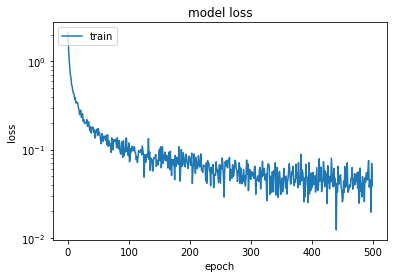

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\0_0_nt1_20210626-090405.jpg 0 -1


ziffer_sortiert_resize\0_D6_2020-08-16_01-02-52.jpg 0 8


ziffer_sortiert_resize\2_10_dig6_20210726-190157.jpg 2 -1


ziffer_sortiert_resize\4_4_dig6_20210724-184309.jpg 4 -1


ziffer_sortiert_resize\4_4_nt7_20210626-035009.jpg 4 -1


ziffer_sortiert_resize\7_10_ht6_20210703-133250.jpg 7 -1


ziffer_sortiert_resize\8_8_wwb.jpg 8 9


ziffer_sortiert_resize\NaN_6_dig6_20210720-121946.jpg -1 8


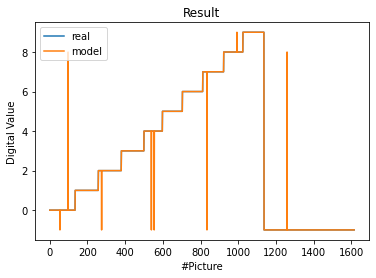

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp1742ixkx\assets


1302912

In [8]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + "q" + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpkvi_5r7_\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpkvi_5r7_\assets


dig1330s1q.tflite


338000

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.